In [45]:
import os
from PIL import Image, ImageOps
import numpy as np

def load_image_data(data_dir, image_size=(64, 64)):
    X, y, class_names = [], [], sorted(os.listdir(data_dir))

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            try:
                img = Image.open(fpath).convert("L")               # Grayscale RGB(3채널)를 1채널로 줄이면 데이터가 간결해짐
                img = ImageOps.equalize(img)                       # Histogram Equalization, 명암 대비를 높여서 패턴이 더 뚜렷하게 보이게 함
                img = img.resize(image_size) # 모든 이미지를 같은 크기로 만듦
                img_np = np.array(img).flatten()                  # Flatten to 1D vector, 2D 이미지를 1D 벡터로 변환
                X.append(img_np)
                y.append(label)
            except:
                continue
    return np.array(X), np.array(y), class_names
    # PDF에 들어있음 

In [46]:
data_dir = "data"
X, y, class_names = load_image_data(data_dir)

print("데이터 로딩 완료:", X.shape) #(샘플 수, 이미지의 총 픽셀 수)
print("클래스:", class_names)

데이터 로딩 완료: (4188, 4096)
클래스: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


### 이미지 데이터화 모델 임포트

In [14]:
# !pip install umap-learn

In [47]:
from sklearn.decomposition import PCA
# PCA 적용
def apply_pca(X, n_components=2):
    pca = PCA(n_components=n_components, whiten=True, random_state=42)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

import umap
# UMAP 적용
def apply_umap(X, n_components=2):
    umap_model = umap.UMAP(n_components=n_components, n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap_model.fit_transform(X)
    return X_umap, umap_model

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# LDA 적용 (y 라벨 필요)
def apply_lda(X, y, n_components=2):
    lda = LDA(n_components=n_components)
    X_lda = lda.fit_transform(X, y)
    return X_lda, lda

In [48]:
# 시각화 코드

import matplotlib.pyplot as plt

def plot_2d(X_2d, y, class_names):
    plt.figure(figsize=(8, 6))
    for i, name in enumerate(class_names):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], label=name, alpha=0.6)
    plt.legend()
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

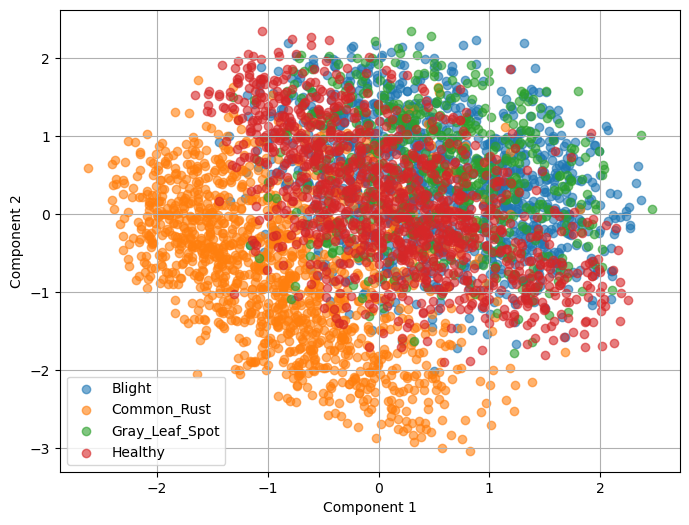

In [49]:
# PCA 적용
X_pca, _ = apply_pca(X, n_components=2)
plot_2d(X_pca, y, class_names)

C:\Users\yYoung\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


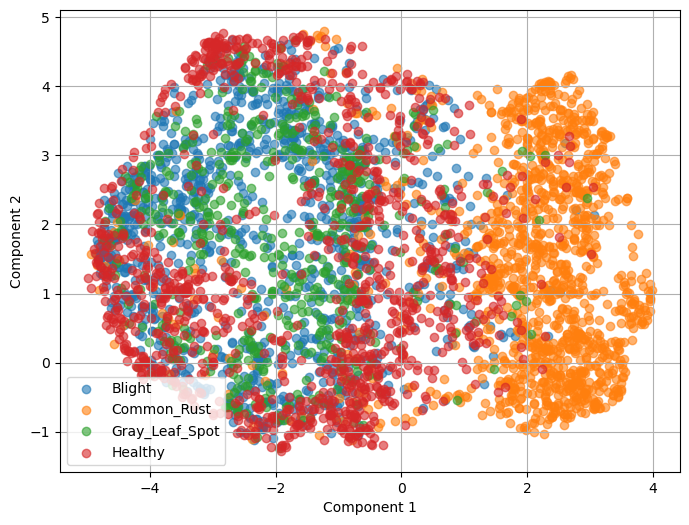

In [38]:
# UMAP 적용
X_umap, _ = apply_umap(X, n_components=2)
plot_2d(X_umap, y, class_names)

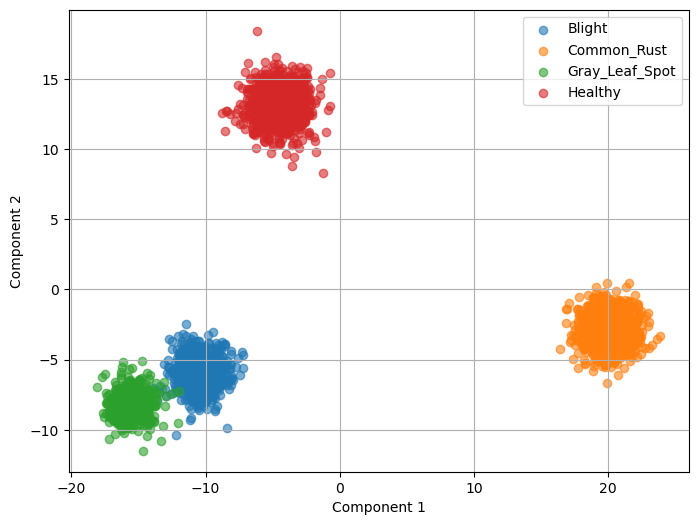

In [39]:
# LDA 적용 (클래스 수 - 1 = 3 까지만 가능)
X_lda, _ = apply_lda(X, y, n_components=2)
plot_2d(X_lda, y, class_names)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# 분류기 정의
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="rbf", gamma='scale'),
    "RF": RandomForestClassifier(n_estimators=100, random_state=42)
}

# 전처리 정의
reducers = {
    "PCA": lambda X, y: apply_pca(X, n_components=30)[0],
    "UMAP": lambda X, y: apply_umap(X, n_components=10)[0],
    "LDA": lambda X, y: apply_lda(X, y, n_components=3)[0]
}

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 결과 저장
results = {}

# 전체 조합 실행
for reducer_name, reducer_func in reducers.items():
    X_train_reduced = reducer_func(X_train, y_train)
    X_test_reduced = reducer_func(X_test, y_test)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_reduced, y_train) # 모델 훈련
        y_pred = clf.predict(X_test_reduced)
        acc = accuracy_score(y_test, y_pred)

        key = f"{reducer_name} + {clf_name}"
        results[key] = acc
        print(f"{key}: Accuracy = {acc:.4f}")

PCA + KNN: Accuracy = 0.4805
PCA + SVM: Accuracy = 0.6165
PCA + RF: Accuracy = 0.6301


C:\Users\yYoung\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\yYoung\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP + KNN: Accuracy = 0.3071
UMAP + SVM: Accuracy = 0.3071
UMAP + RF: Accuracy = 0.3994
LDA + KNN: Accuracy = 0.9976
LDA + SVM: Accuracy = 0.9817
LDA + RF: Accuracy = 0.9491


In [55]:
# 테스트 이미지 로딩
test_dir = "Test"
X_test_raw, test_filenames = preprocess_test_images(test_dir)

# ✅ 이미 학습된 LDA + KNN 모델로부터 예측하려면 → 먼저 학습시켜야 함
# 아래는 가정: 학습용 X, y, class_names 존재

# 1. LDA 학습
lda_model = LDA(n_components=3)
X_lda = lda_model.fit_transform(X, y)

# 2. KNN 학습
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_lda, y)

# 3. 테스트 데이터 변환 및 예측
X_test_lda = lda_model.transform(X_test_raw)
y_pred = knn_model.predict(X_test_lda)

# 4. 예측 결과 정리
predicted_classes = [class_names[i] for i in y_pred]
results_df = pd.DataFrame(zip(test_filenames, predicted_classes), columns=["파일명", "예측 클래스"])

# 결과 출력
print(results_df)

                       파일명          예측 클래스
0          Blight (23).jpg          Blight
1          Blight (24).jpg          Blight
2          Blight (25).jpg          Blight
3          Blight (26).jpg          Blight
4     Common_Rust (12).jpg     Common_Rust
5     Common_Rust (13).jpg     Common_Rust
6     Common_Rust (14).jpg     Common_Rust
7     Common_Rust (15).jpg     Common_Rust
8      Common_Rust(11).jpg     Common_Rust
9   Gray_Leaf_Spot(12).jpg  Gray_Leaf_Spot
10  Gray_Leaf_Spot(13).jpg  Gray_Leaf_Spot
11      Gray_Spot (11).jpg  Gray_Leaf_Spot
12        Health (111).jpg         Healthy
13        Health (112).jpg         Healthy
14        Health (113).jpg         Healthy
15        Health (121).jpg         Healthy
16        Health (122).jpg         Healthy
17        Health (123).jpg         Healthy
